In [1]:
# Loading Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten, RNN, SimpleRNN
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras import optimizers
from matplotlib import pyplot

import warnings
warnings.filterwarnings("ignore")

C:\Users\chris\anaconda4\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\chris\anaconda4\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\chris\anaconda4\lib\site-packages\numpy\.libs\libopenblas.xwydx2ikjw2nmtwsfyngfuwkqu3lytcz.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Reading data
greece_inflation = pd.read_csv('Inflation and Parameters.csv', index_col=0)
greece_inflation.head()

,Cpi,Food Price Index,Energy Price Index,Hicp,Unemployment Rate,Gdp,Rent Price,House Prices,Lci
Date,,,,,,,,,
2001-01-01,0.001806,0.016060,0.111474,0.003837,0.109312,0.000000,0.000000,0.315560,0.000000
2001-02-01,0.000000,0.011688,0.097947,0.000000,0.110324,0.005330,0.006099,0.328415,0.017084
2001-03-01,0.036626,0.008565,0.077760,0.042722,0.110324,0.010660,0.012198,0.341270,0.034167
2001-04-01,0.054424,0.003301,0.082858,0.063443,0.118421,0.015991,0.018297,0.354126,0.051251
2001-05-01,0.062677,0.009190,0.087208,0.072909,0.117409,0.029163,0.025907,0.352209,0.054301


In [3]:
# with the function generate_sequences we create the appropriate sequences for training the model
def generate_sequences(time_series, n_steps):
    window, output = list(), list()
    
    for i in range(len(time_series)):

        # n_steps is the number of previous months we use so
         # predict the next month
        window_limit = i + n_steps

        # as soon as the last sequence is made, the function
         # returns the set of sequences
        if window_limit > len(time_series):
            break

        # we store each sequence in a list, which are the input of the model
         # At the same time, we store the target value in a separate list
        input_features, output_features = time_series[i:window_limit,:], time_series[window_limit-1,0]

        window.append(input_features)
        output.append(output_features)
        
    return np.asarray(window).astype('float32'), np.asarray(output).astype('float32')

In [4]:
# indexes and external data
greece_inflation.columns

Index(['Cpi', 'Food Price Index', 'Energy Price Index', 'Hicp',
       'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices', 'Lci'],
      dtype='object')

In [5]:
# indexes and external data
cols = ['Cpi', 'Food Price Index', 'Energy Price Index', 'Hicp','Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices', 'Lci']

In [6]:
greece_inflation_multi = greece_inflation.loc[:, greece_inflation.columns.intersection(cols)]
greece_inflation_multi = greece_inflation_multi.apply(pd.to_numeric, errors='coerce')

In [7]:
greece_inflation_multi = greece_inflation_multi.fillna(method='bfill')
(greece_inflation_multi).isna().sum()

Cpi                   0
Food Price Index      0
Energy Price Index    0
Hicp                  0
Unemployment Rate     0
Gdp                   0
Rent Price            0
House Prices          0
Lci                   0
dtype: int64

In [8]:
# separate the external data and the indexes we aim to predict
inflation_indexes = ['Cpi', 'Hicp']
external_factors = ['Food Price Index', 'Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices', 'Lci']

In [9]:
# creation of CPI dataset with the external data
cpi_inflation = greece_inflation_multi.loc[:, greece_inflation_multi.columns.intersection(['Food Price Index',
                                                                                           'Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices', 'Lci', 'Cpi'])]

In [10]:
# creation of HICP dataset with the external data
hicp_inflation = greece_inflation_multi.loc[:, greece_inflation_multi.columns.intersection(['Food Price Index',
                                                                                           'Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices', 'Lci', 'Hicp'])]

In [11]:
cpi_inflation

,Cpi,Food Price Index,Energy Price Index,Unemployment Rate,Gdp,Rent Price,House Prices,Lci
Date,,,,,,,,
2001-01-01,0.001806,0.016060,0.111474,0.109312,0.000000,0.000000,0.315560,0.000000
2001-02-01,0.000000,0.011688,0.097947,0.110324,0.005330,0.006099,0.328415,0.017084
2001-03-01,0.036626,0.008565,0.077760,0.110324,0.010660,0.012198,0.341270,0.034167
2001-04-01,0.054424,0.003301,0.082858,0.118421,0.015991,0.018297,0.354126,0.051251
2001-05-01,0.062677,0.009190,0.087208,0.117409,0.029163,0.025907,0.352209,0.054301
...,...,...,...,...,...,...,...,...
2021-12-01,0.841888,0.718415,0.584965,0.235830,0.531242,0.232332,0.305757,0.318080
2022-01-01,0.834924,0.776499,0.645731,0.261134,0.567558,0.235046,0.303382,0.303234
2022-02-01,0.864844,0.843772,0.713431,0.253036,0.595143,0.236799,0.314397,0.319300


In [12]:
hicp_inflation = hicp_inflation.reindex(columns=(['Hicp','Food Price Index','Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices', 'Lci']))
hicp_inflation.head()

,Hicp,Food Price Index,Energy Price Index,Unemployment Rate,Gdp,Rent Price,House Prices,Lci
Date,,,,,,,,
2001-01-01,0.003837,0.016060,0.111474,0.109312,0.000000,0.000000,0.315560,0.000000
2001-02-01,0.000000,0.011688,0.097947,0.110324,0.005330,0.006099,0.328415,0.017084
2001-03-01,0.042722,0.008565,0.077760,0.110324,0.010660,0.012198,0.341270,0.034167
2001-04-01,0.063443,0.003301,0.082858,0.118421,0.015991,0.018297,0.354126,0.051251
2001-05-01,0.072909,0.009190,0.087208,0.117409,0.029163,0.025907,0.352209,0.054301


In [13]:
datasets = [cpi_inflation, hicp_inflation]

In [14]:
# RNN implementation to predict the two indexes
def Multi_RNN():
    
    preds = []
    tests = []

    for data in datasets:
        
        window, output = generate_sequences(np.asarray(data), n_steps)

        n_features = window.shape[2]

        # multivariate RNN model
        model = Sequential()
        model.add(SimpleRNN(50, activation='relu', input_shape=(n_steps, n_features), return_sequences = False))
        model.add(Dense(30))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='relu'))
        optimizer = optimizers.RMSprop(lr=0.0001)
        model.compile(optimizer=optimizer, loss='mse')

        # Split the data into train and test
        train_size = int(len(output) * 0.8)
        train_X, test_X = window[0:train_size], window[train_size:]
        train_y, test_y = output[0:train_size], output[train_size:]

        # model fit
        model.fit(train_X, train_y, epochs=1000, verbose=0)

        test_X = test_X.reshape((test_X.shape[0], n_steps, n_features))

        # prediction based on test data
        pred = model.predict(test_X, verbose=0)
        
        # δημιουργία των λιστών actual και predicted values
        preds.append(pred)
        tests.append(test_y)

        # calculation of error metrics
        mse = mean_squared_error(test_y, pred)
        rmse = math.sqrt(mean_squared_error(test_y, pred))
        mae = mean_absolute_error(test_y, pred)
        mape = mean_absolute_percentage_error(test_y, pred)

        print("Multivariate RNN MSE for [" + str(data.columns[0]) + "]:" + str(mse))
        print("Multivariate RNN RMSE for [" + str(data.columns[0]) + "]:" + str(rmse))
        print("Multivariate RNN MAE for [" + str(data.columns[0]) + "]:" + str(mae))

        title = "Mutlivariate RNN for " + "[" + str(data.columns[0]) +"]"

        # creation of the charts of actual and predicted data
        plt.figure(figsize=(20, 5))
        plt.title(title)
        plt.plot(test_y, label='Actual Data', color='blue')
        plt.plot(pred, label='Predicted Data', color='red')
        plt.show()
    return preds, tests

Multivariate RNN MSE for [Cpi]:0.00790185
Multivariate RNN RMSE for [Cpi]:0.08889235150723618
Multivariate RNN MAE for [Cpi]:0.07937077


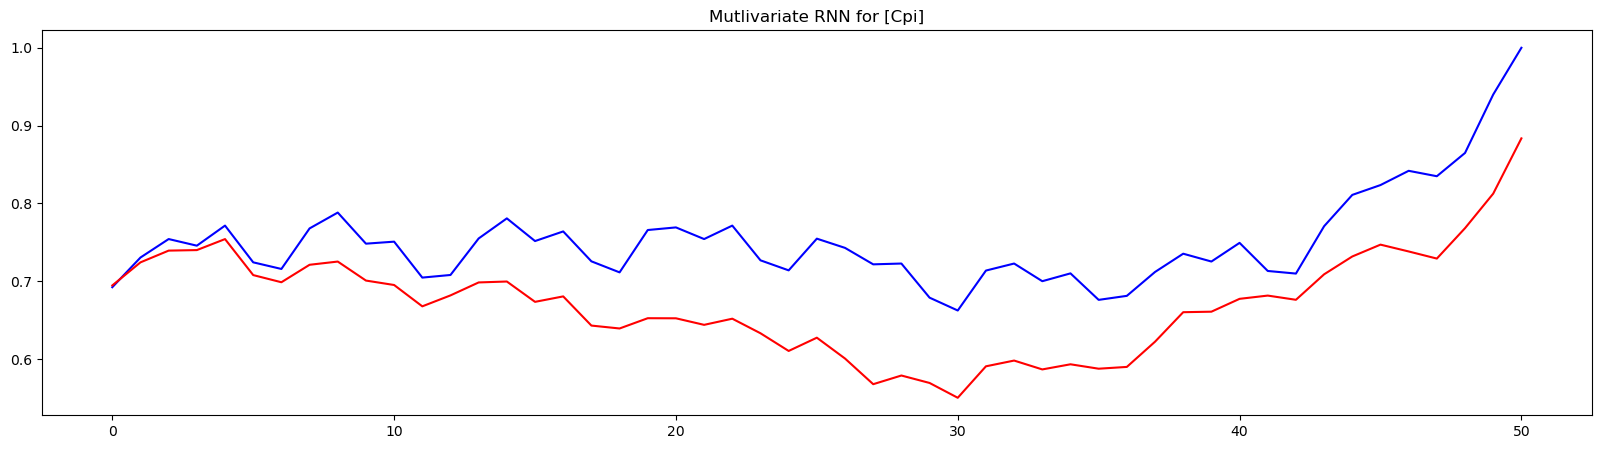

Multivariate RNN MSE for [Hicp]:0.022921138
Multivariate RNN RMSE for [Hicp]:0.15139728369997327
Multivariate RNN MAE for [Hicp]:0.13529068


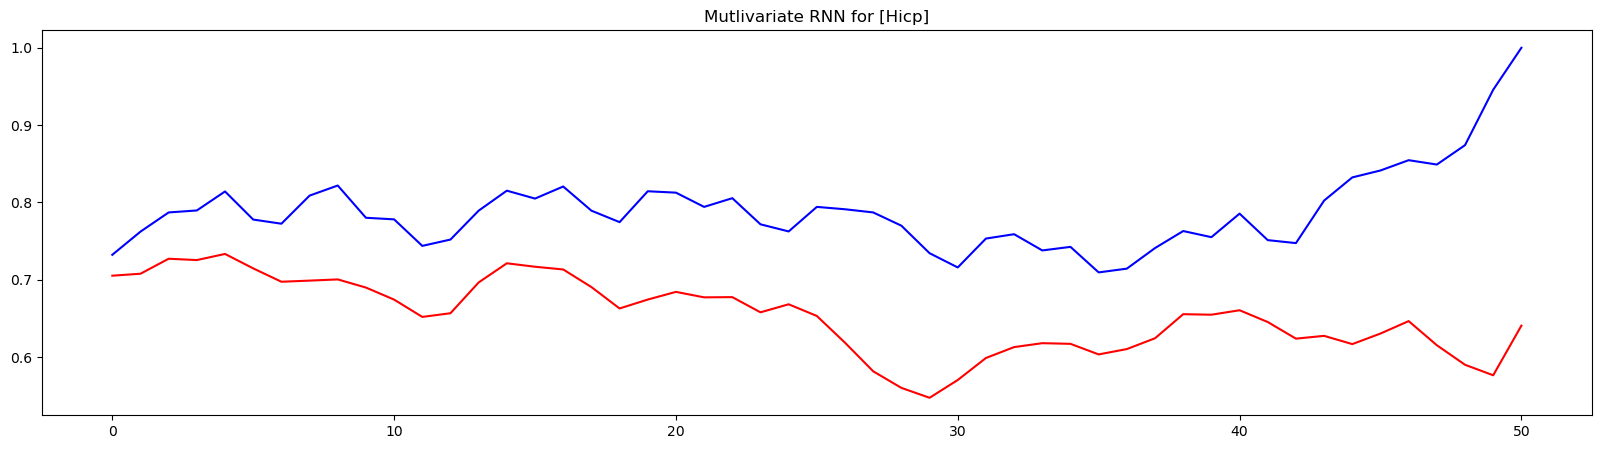

In [15]:
# declaration of the steps to create the sequences
n_steps=5
pred, test = Multi_RNN()

In [16]:
cpi_inflation.head()

,Cpi,Food Price Index,Energy Price Index,Unemployment Rate,Gdp,Rent Price,House Prices,Lci
Date,,,,,,,,
2001-01-01,0.001806,0.016060,0.111474,0.109312,0.000000,0.000000,0.315560,0.000000
2001-02-01,0.000000,0.011688,0.097947,0.110324,0.005330,0.006099,0.328415,0.017084
2001-03-01,0.036626,0.008565,0.077760,0.110324,0.010660,0.012198,0.341270,0.034167
2001-04-01,0.054424,0.003301,0.082858,0.118421,0.015991,0.018297,0.354126,0.051251
2001-05-01,0.062677,0.009190,0.087208,0.117409,0.029163,0.025907,0.352209,0.054301


In [17]:
hicp_inflation.head()

,Hicp,Food Price Index,Energy Price Index,Unemployment Rate,Gdp,Rent Price,House Prices,Lci
Date,,,,,,,,
2001-01-01,0.003837,0.016060,0.111474,0.109312,0.000000,0.000000,0.315560,0.000000
2001-02-01,0.000000,0.011688,0.097947,0.110324,0.005330,0.006099,0.328415,0.017084
2001-03-01,0.042722,0.008565,0.077760,0.110324,0.010660,0.012198,0.341270,0.034167
2001-04-01,0.063443,0.003301,0.082858,0.118421,0.015991,0.018297,0.354126,0.051251
2001-05-01,0.072909,0.009190,0.087208,0.117409,0.029163,0.025907,0.352209,0.054301


In [18]:
# impact of each external data set on the index
cols = ['Food Price Index','Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices', 'Lci']
def RNN_for_each_index():
    
    # predict indexes based on each external data set
    for col in cols:
        
        cpi_cols = ['Cpi']
        cpi_cols.append(col)
        print('Cpi cols are', cpi_cols)     
        
        hicp_cols = ['Hicp']
        hicp_cols.append(col)
        print('Hicp cols are', hicp_cols)
        print('\n')
        
        cpi_inflation_values = cpi_inflation[cpi_cols]
        hicp_inflation_values = hicp_inflation[hicp_cols]
        
        datasets = [cpi_inflation_values, hicp_inflation_values]
        Multi_RNN()
        
        print('\n\n')

Cpi cols are ['Cpi', 'Food Price Index']
Hicp cols are ['Hicp', 'Food Price Index']


Multivariate RNN MSE for [Cpi]:0.008380801
Multivariate RNN RMSE for [Cpi]:0.09154671712810644
Multivariate RNN MAE for [Cpi]:0.07872897


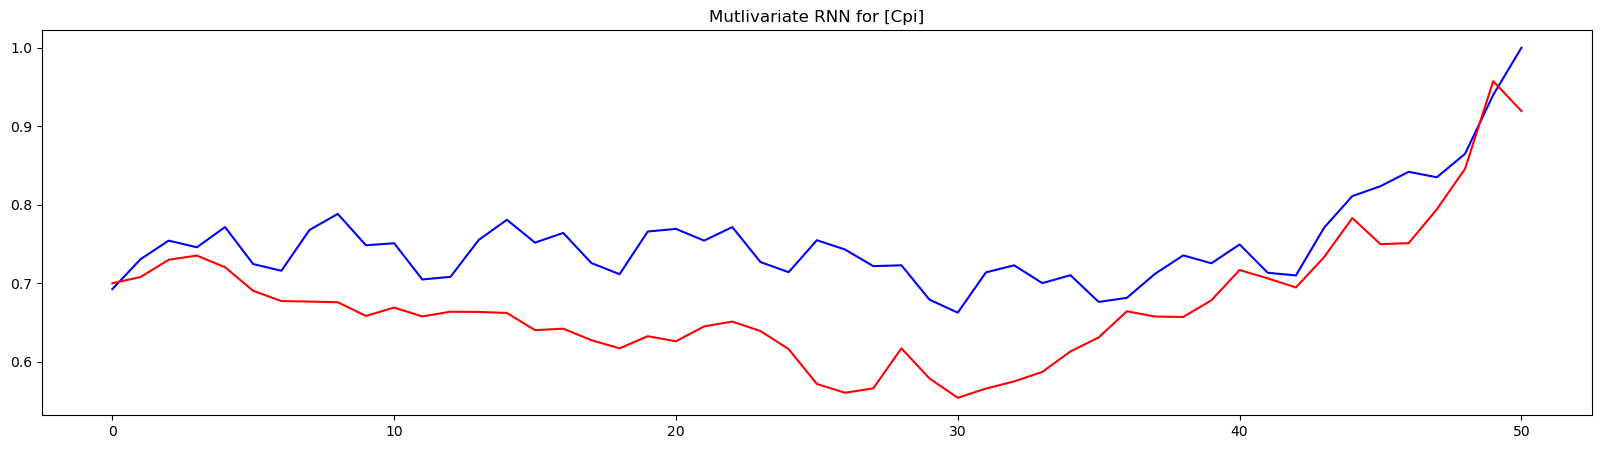

Multivariate RNN MSE for [Hicp]:0.004050178
Multivariate RNN RMSE for [Hicp]:0.06364100869459045
Multivariate RNN MAE for [Hicp]:0.05658128


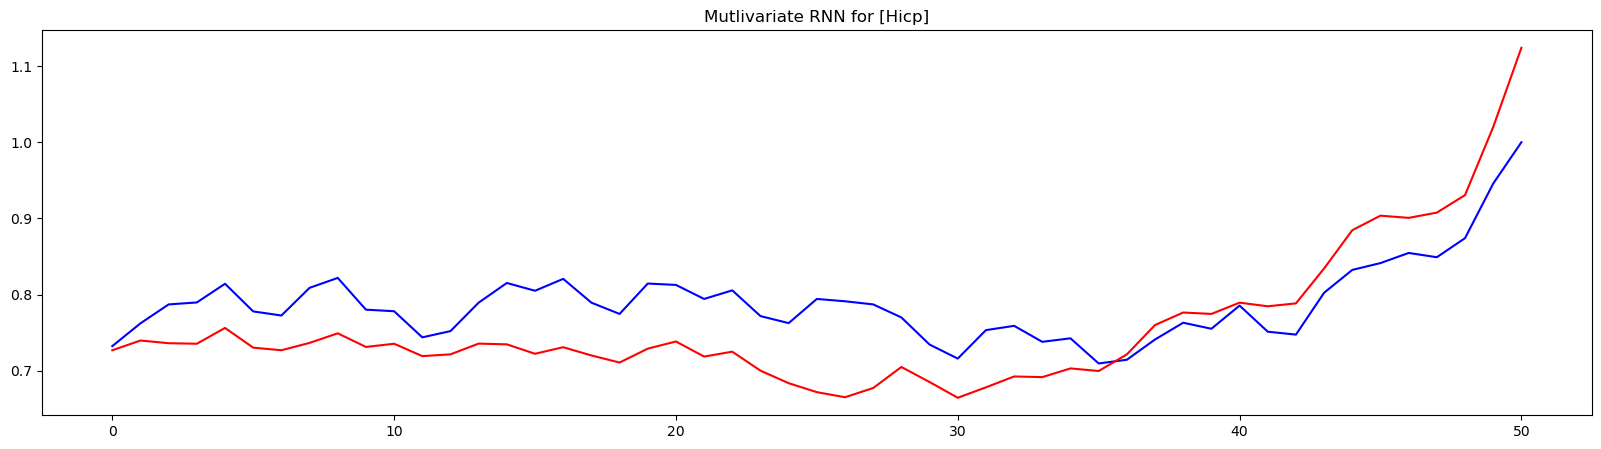




Cpi cols are ['Cpi', 'Energy Price Index']
Hicp cols are ['Hicp', 'Energy Price Index']


Multivariate RNN MSE for [Cpi]:0.002697358
Multivariate RNN RMSE for [Cpi]:0.05193609446128264
Multivariate RNN MAE for [Cpi]:0.037821084


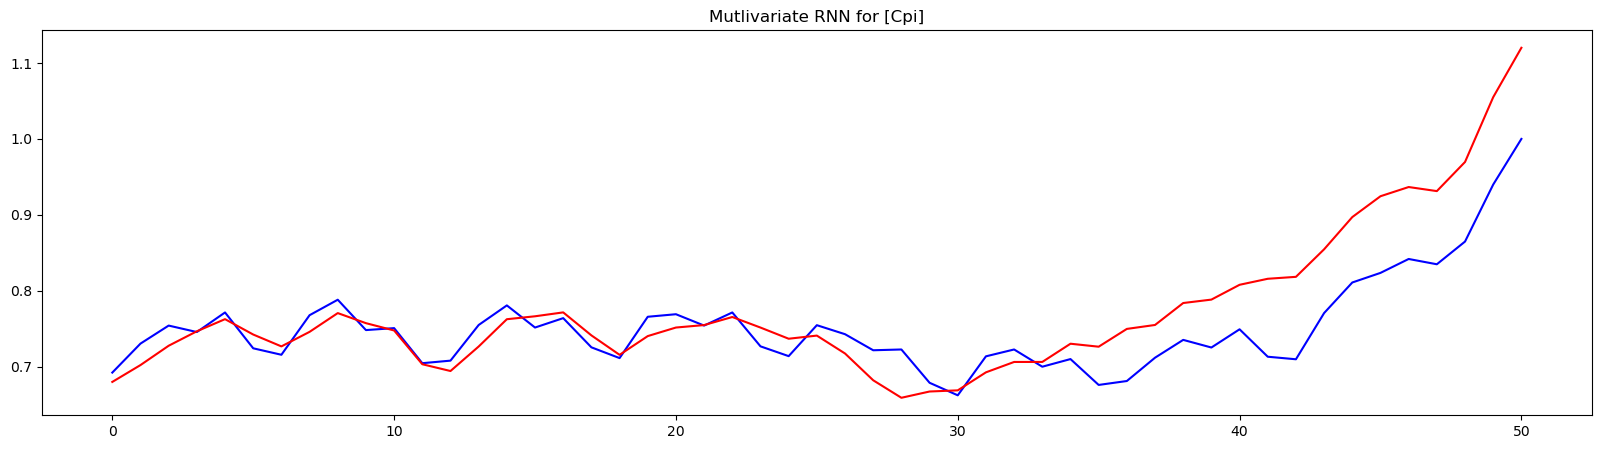

Multivariate RNN MSE for [Hicp]:0.0010083703
Multivariate RNN RMSE for [Hicp]:0.03175484701800353
Multivariate RNN MAE for [Hicp]:0.027185384


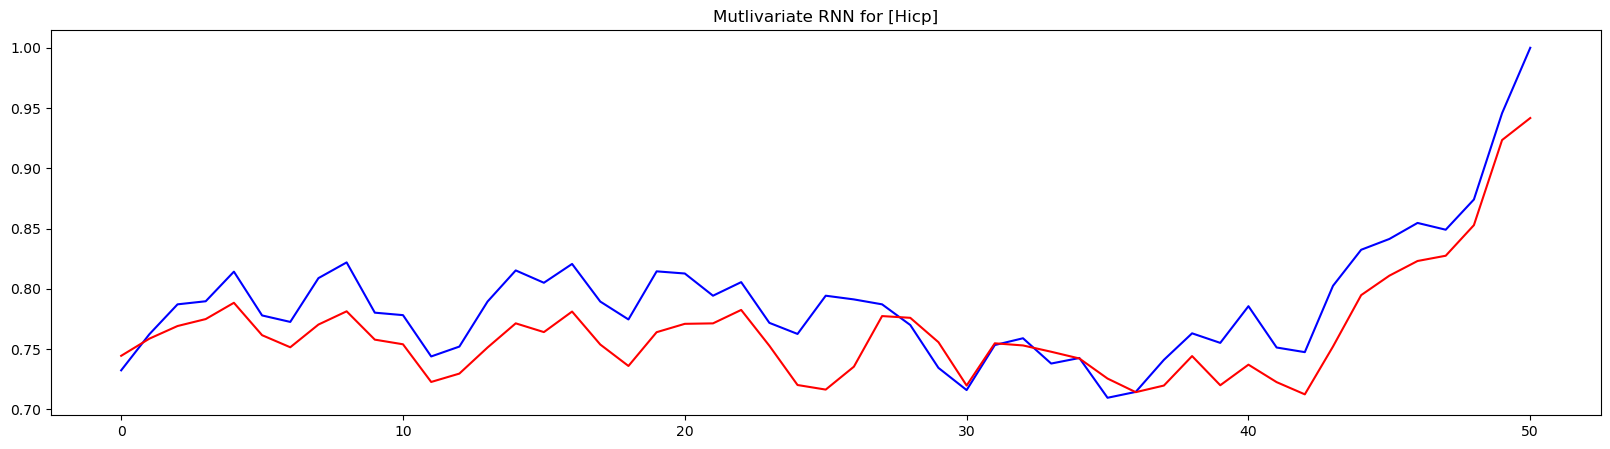




Cpi cols are ['Cpi', 'Unemployment Rate']
Hicp cols are ['Hicp', 'Unemployment Rate']


Multivariate RNN MSE for [Cpi]:0.013721101
Multivariate RNN RMSE for [Cpi]:0.11713710337038336
Multivariate RNN MAE for [Cpi]:0.103835575


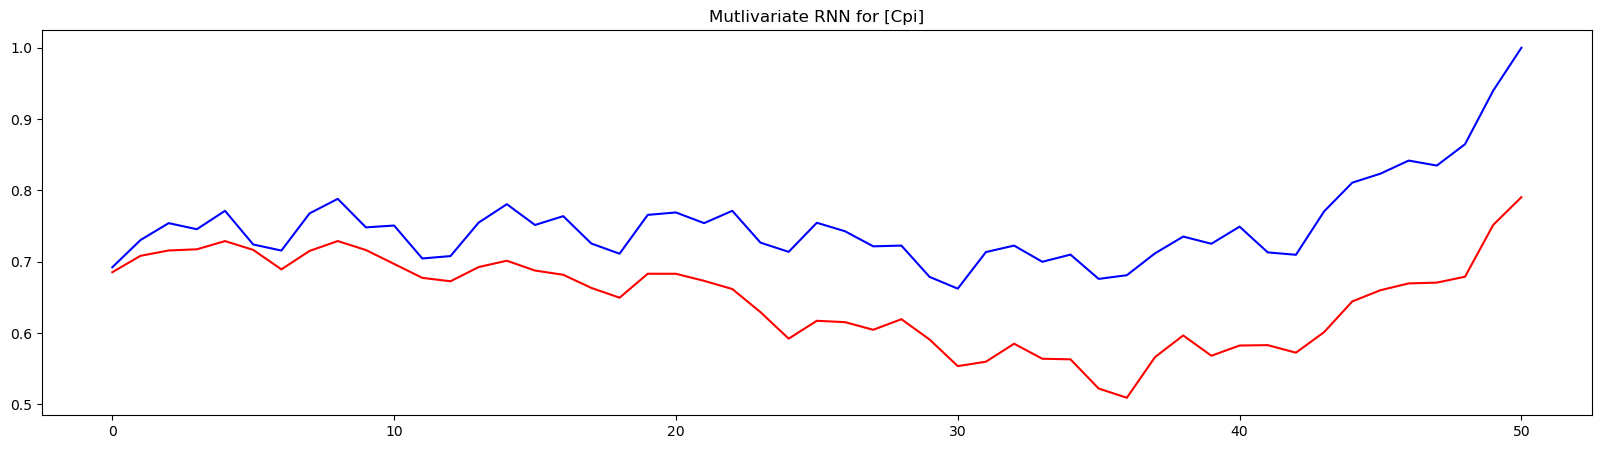

Multivariate RNN MSE for [Hicp]:0.022950528
Multivariate RNN RMSE for [Hicp]:0.1514943173506515
Multivariate RNN MAE for [Hicp]:0.12868275


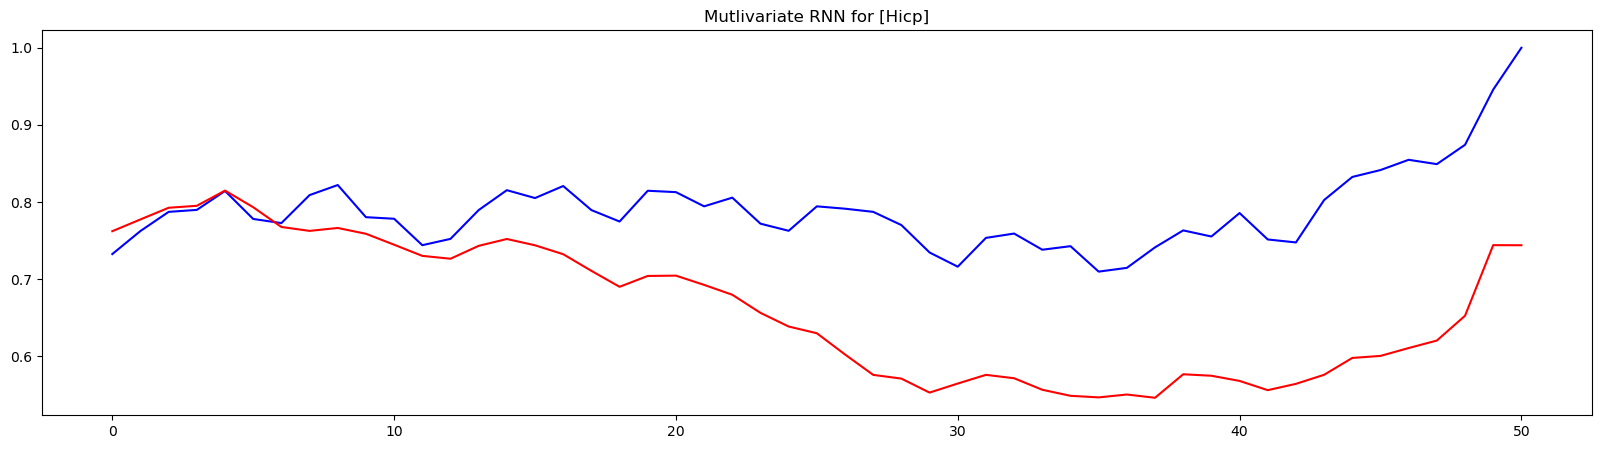




Cpi cols are ['Cpi', 'Gdp']
Hicp cols are ['Hicp', 'Gdp']


Multivariate RNN MSE for [Cpi]:0.0037706848
Multivariate RNN RMSE for [Cpi]:0.061405902186954485
Multivariate RNN MAE for [Cpi]:0.053288758


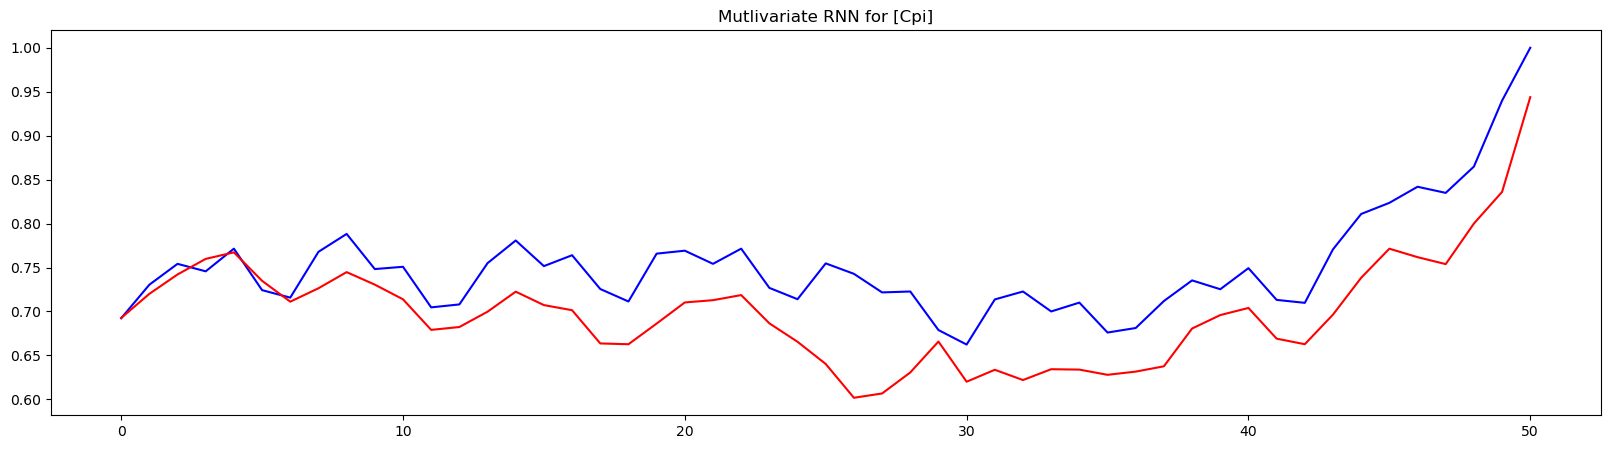

Multivariate RNN MSE for [Hicp]:0.007900712
Multivariate RNN RMSE for [Hicp]:0.08888594984754258
Multivariate RNN MAE for [Hicp]:0.07386032


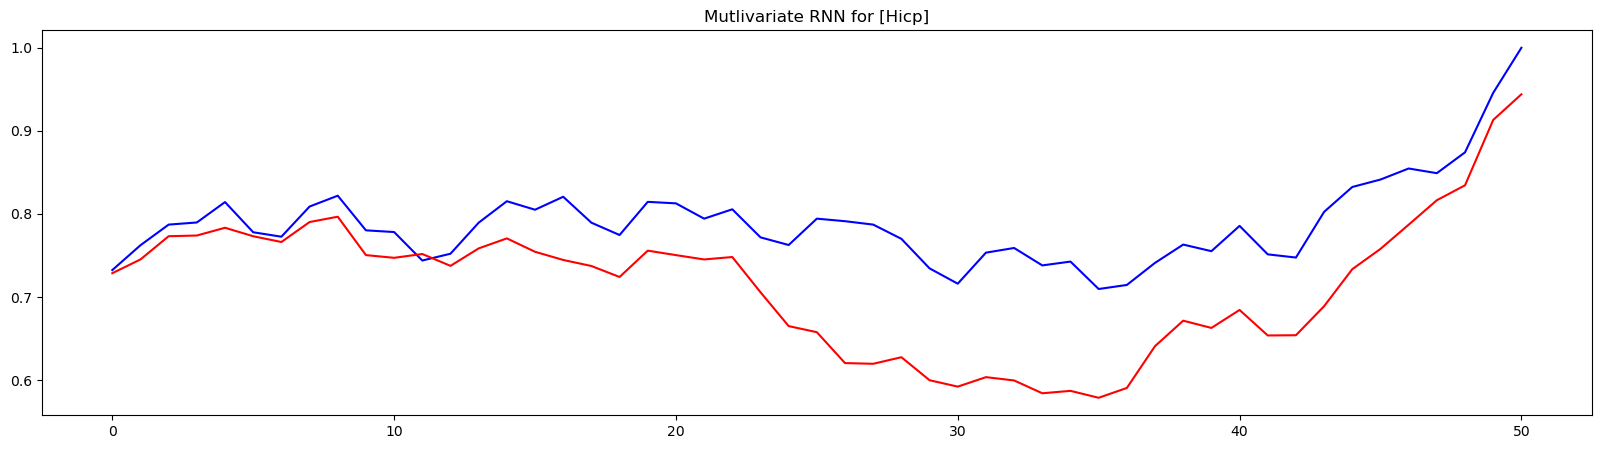




Cpi cols are ['Cpi', 'Rent Price']
Hicp cols are ['Hicp', 'Rent Price']


Multivariate RNN MSE for [Cpi]:0.017021934
Multivariate RNN RMSE for [Cpi]:0.1304681323944824
Multivariate RNN MAE for [Cpi]:0.12041113


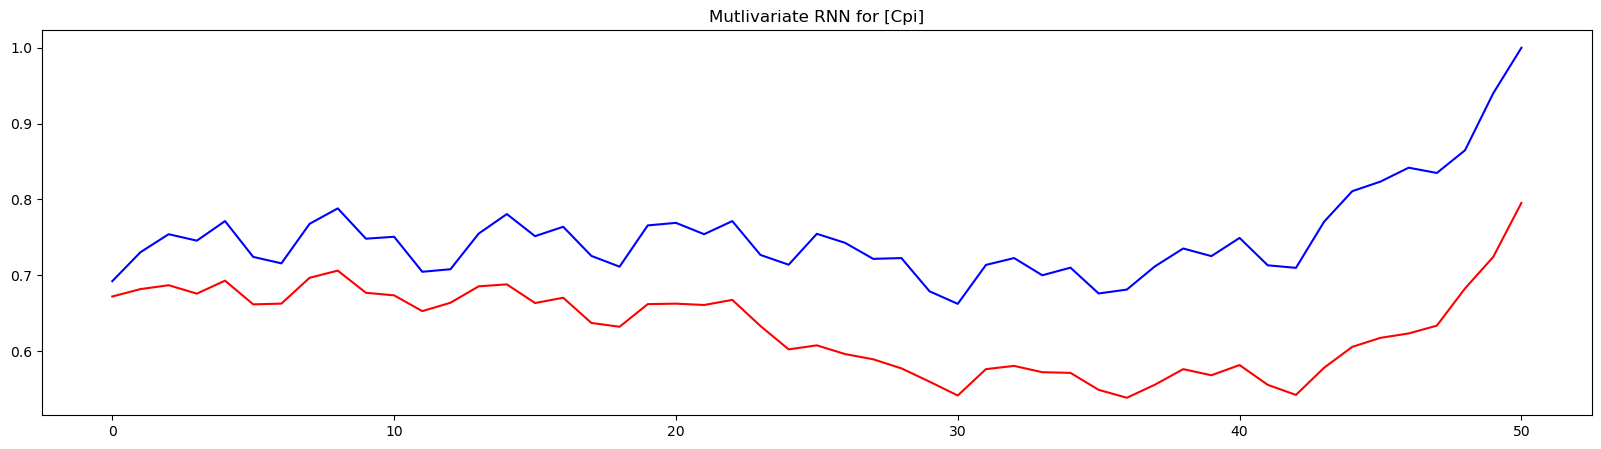

Multivariate RNN MSE for [Hicp]:0.011309274
Multivariate RNN RMSE for [Hicp]:0.10634506824941936
Multivariate RNN MAE for [Hicp]:0.094412886


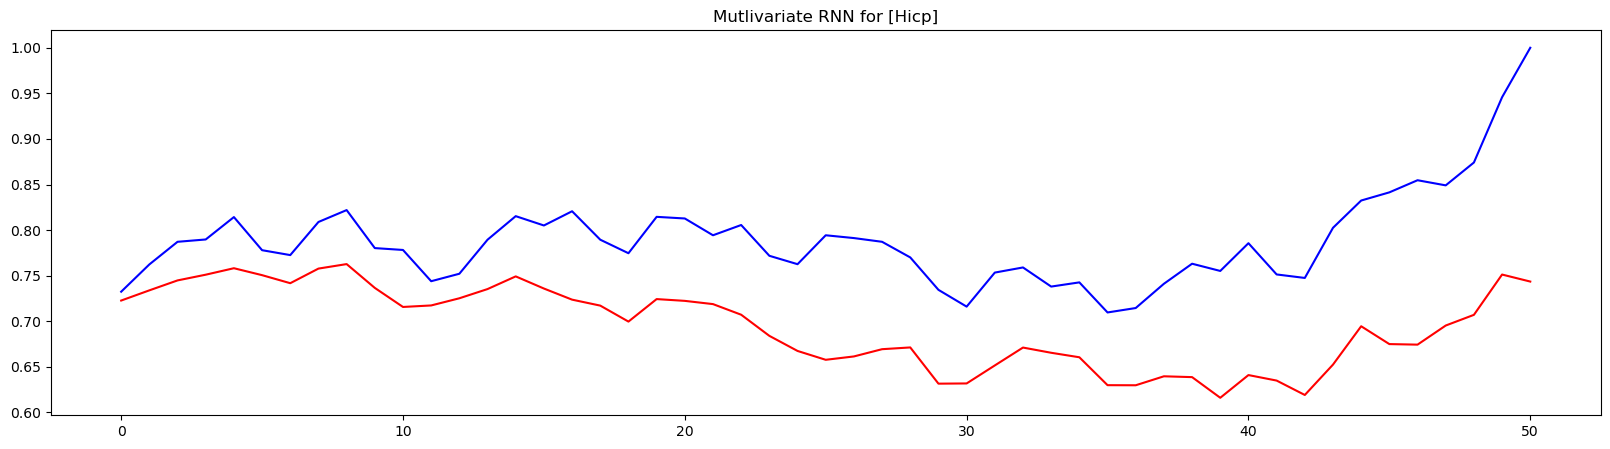




Cpi cols are ['Cpi', 'House Prices']
Hicp cols are ['Hicp', 'House Prices']


Multivariate RNN MSE for [Cpi]:0.011086868
Multivariate RNN RMSE for [Cpi]:0.10529419795135932
Multivariate RNN MAE for [Cpi]:0.093195006


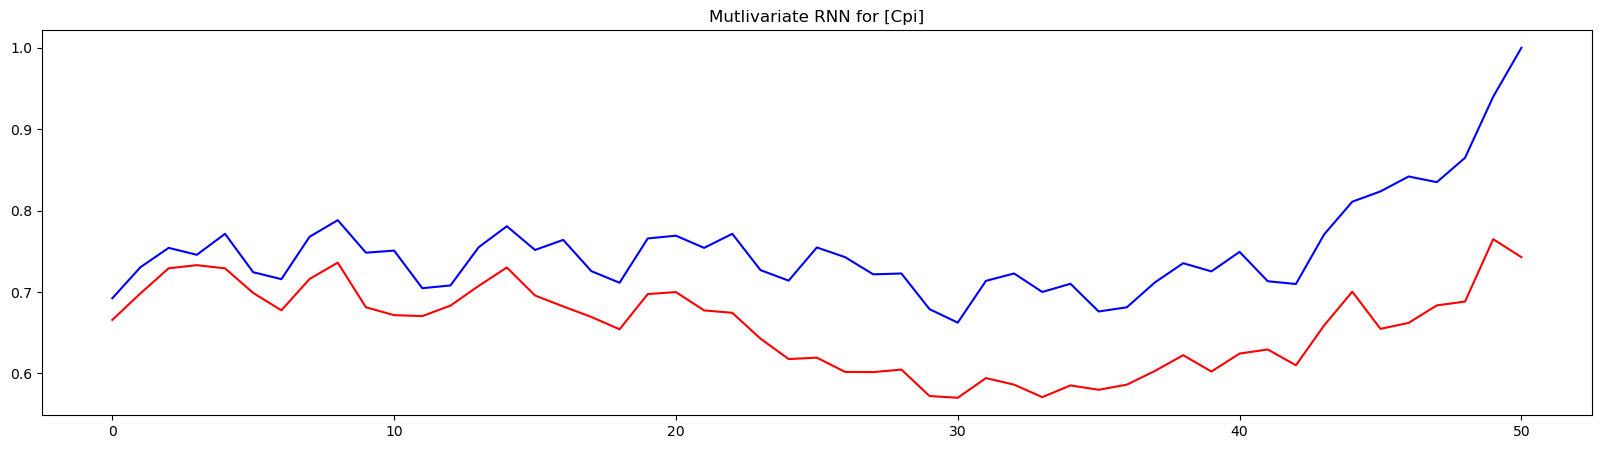

Multivariate RNN MSE for [Hicp]:0.0028827067
Multivariate RNN RMSE for [Hicp]:0.05369084372491159
Multivariate RNN MAE for [Hicp]:0.042151965


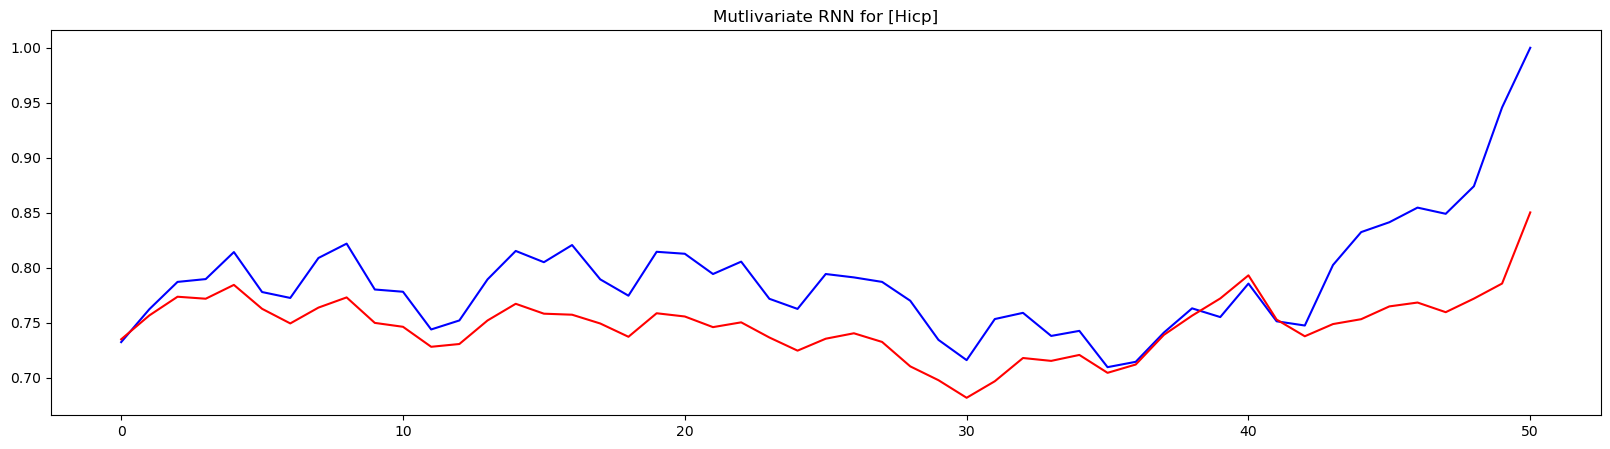




Cpi cols are ['Cpi', 'Lci']
Hicp cols are ['Hicp', 'Lci']


Multivariate RNN MSE for [Cpi]:0.006082768
Multivariate RNN RMSE for [Cpi]:0.07799210271780088
Multivariate RNN MAE for [Cpi]:0.065217964


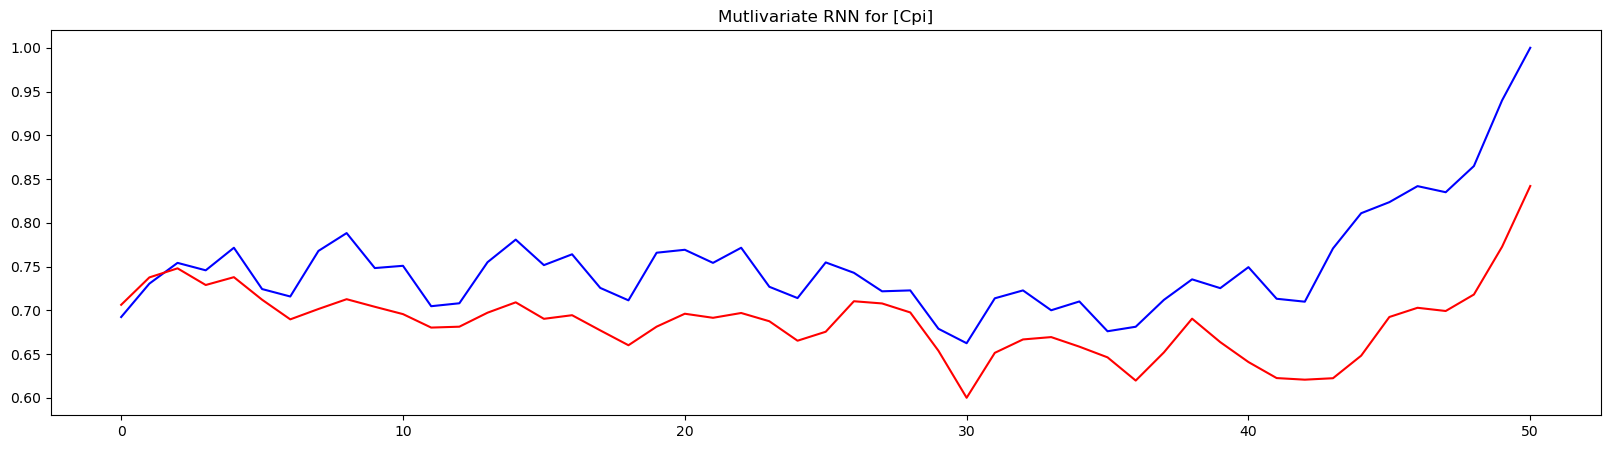

Multivariate RNN MSE for [Hicp]:0.01888371
Multivariate RNN RMSE for [Hicp]:0.1374180145653968
Multivariate RNN MAE for [Hicp]:0.12043694


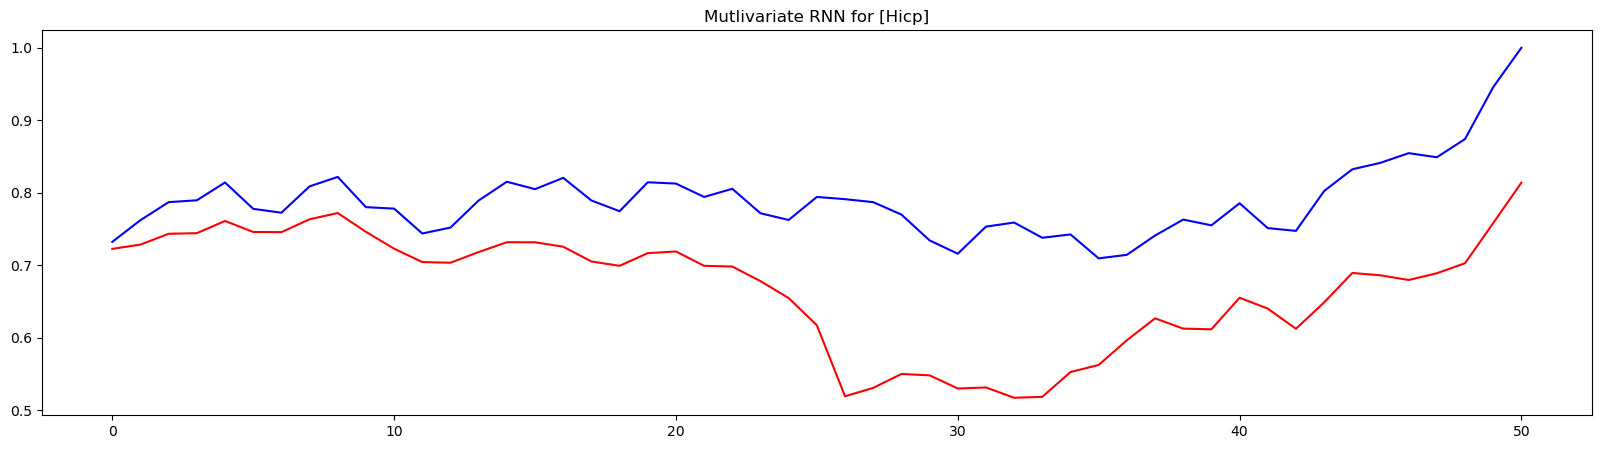

In [19]:
RNN_for_each_index()

In [20]:
# prediction of indexes using in each iteration an additional external factor
cols = ['Food Price Index','Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices', 'Lci']
def RNN_adding_cols():
    
    cpi_cols = ['Cpi']
    hicp_cols = ['Hicp']
    
    for col in cols:
           
        cpi_cols.append(col)
        print('Cpi cols are', cpi_cols)     
        
        hicp_cols.append(col)
        print('Hicp cols are', hicp_cols)
        print('\n')
        
        cpi_inflation_values = cpi_inflation[cpi_cols]
        hicp_inflation_values = hicp_inflation[hicp_cols]
        
        datasets = [cpi_inflation_values, hicp_inflation_values]
        Multi_RNN()
        
        print('\n\n')

Cpi cols are ['Cpi', 'Food Price Index']
Hicp cols are ['Hicp', 'Food Price Index']


Multivariate RNN MSE for [Cpi]:0.007639246
Multivariate RNN RMSE for [Cpi]:0.08740278062764527
Multivariate RNN MAE for [Cpi]:0.07515357


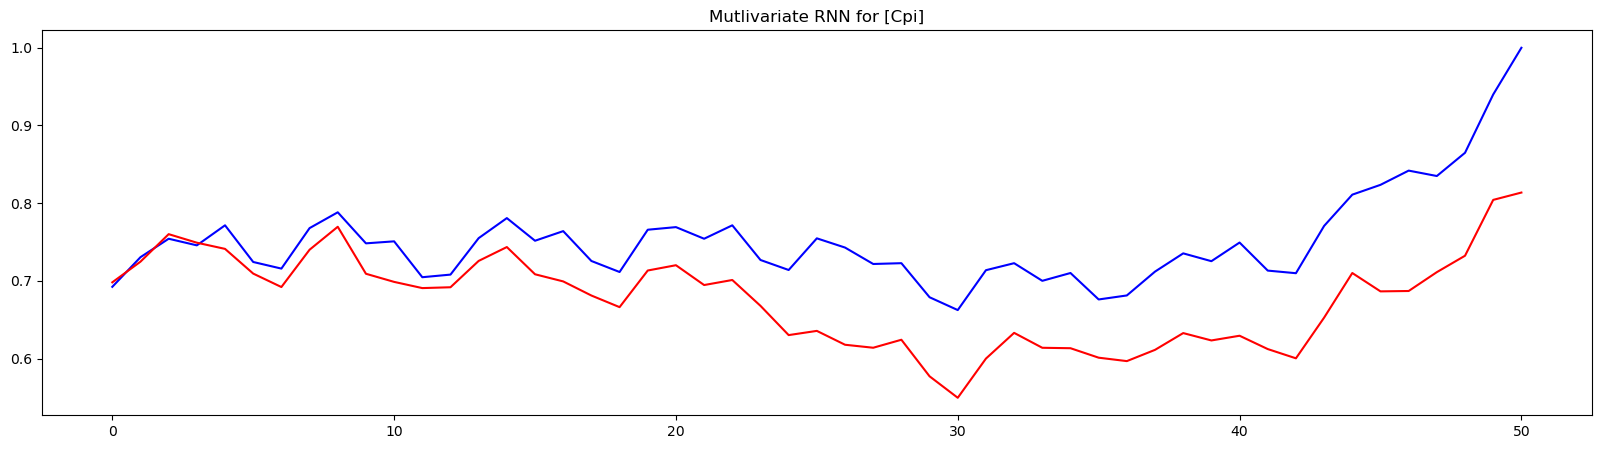

Multivariate RNN MSE for [Hicp]:0.0017569489
Multivariate RNN RMSE for [Hicp]:0.04191597409790877
Multivariate RNN MAE for [Hicp]:0.035169326


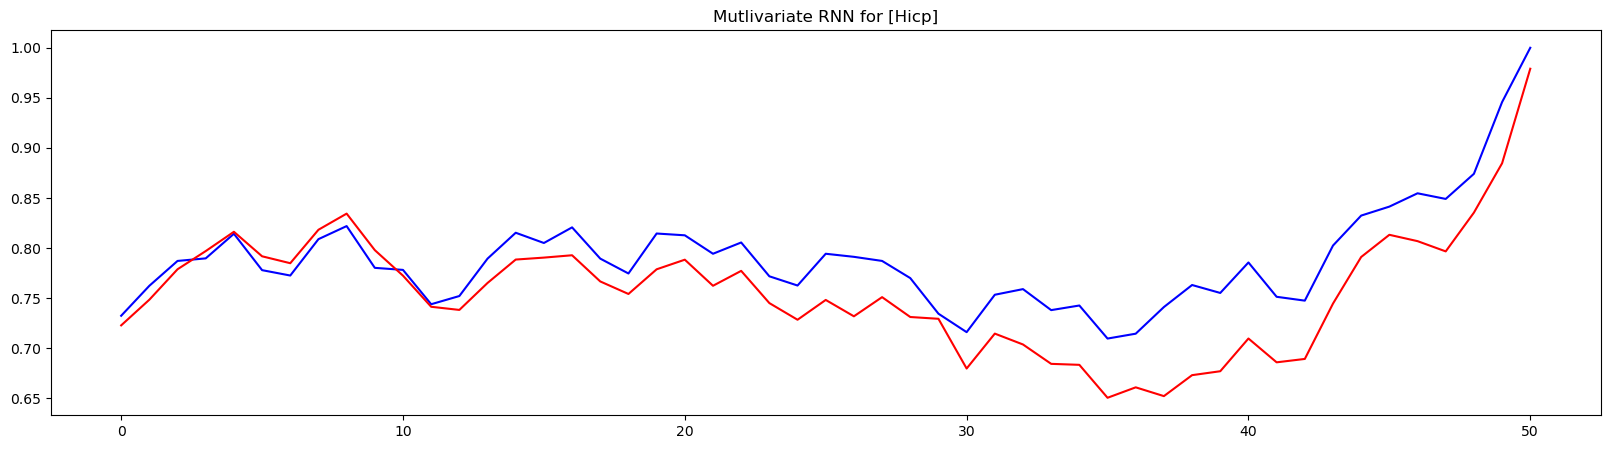




Cpi cols are ['Cpi', 'Food Price Index', 'Energy Price Index']
Hicp cols are ['Hicp', 'Food Price Index', 'Energy Price Index']


Multivariate RNN MSE for [Cpi]:0.010558166
Multivariate RNN RMSE for [Cpi]:0.10275293479914127
Multivariate RNN MAE for [Cpi]:0.09477534


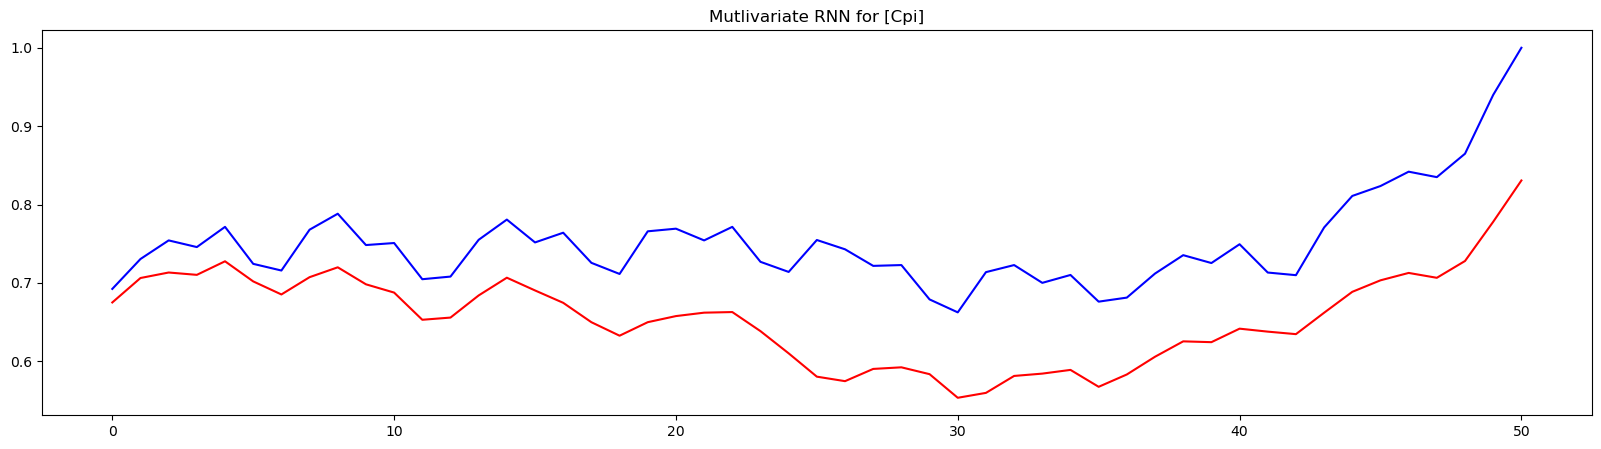

Multivariate RNN MSE for [Hicp]:0.014735361
Multivariate RNN RMSE for [Hicp]:0.12138929372006654
Multivariate RNN MAE for [Hicp]:0.11168882


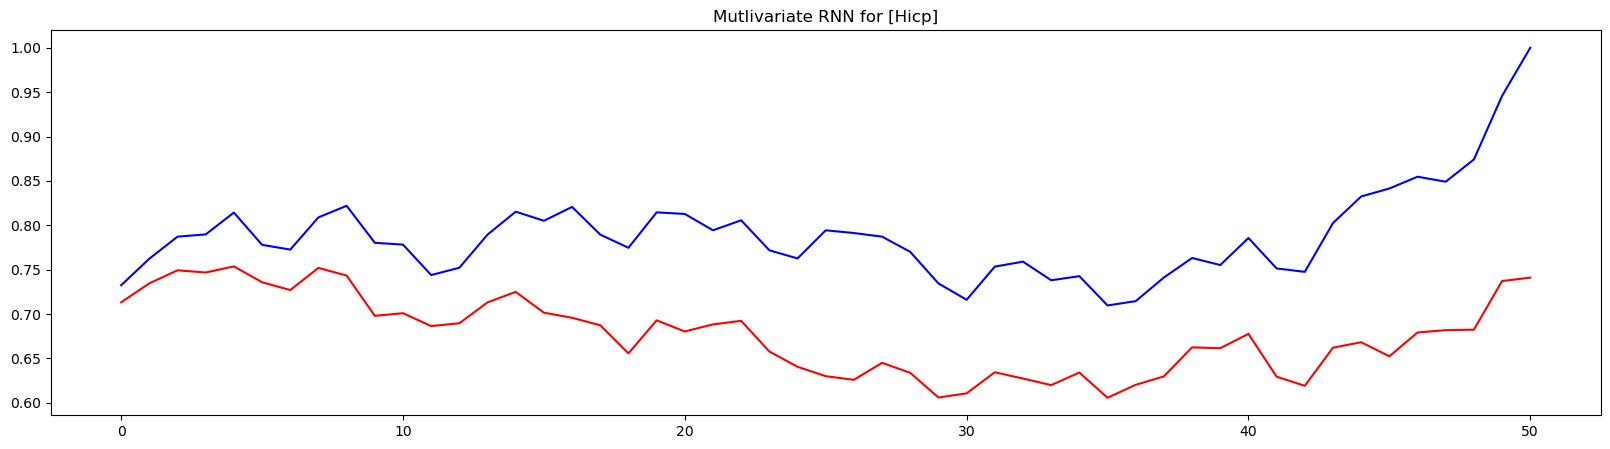




Cpi cols are ['Cpi', 'Food Price Index', 'Energy Price Index', 'Unemployment Rate']
Hicp cols are ['Hicp', 'Food Price Index', 'Energy Price Index', 'Unemployment Rate']


Multivariate RNN MSE for [Cpi]:0.01537561
Multivariate RNN RMSE for [Cpi]:0.12399842918750813
Multivariate RNN MAE for [Cpi]:0.10998926


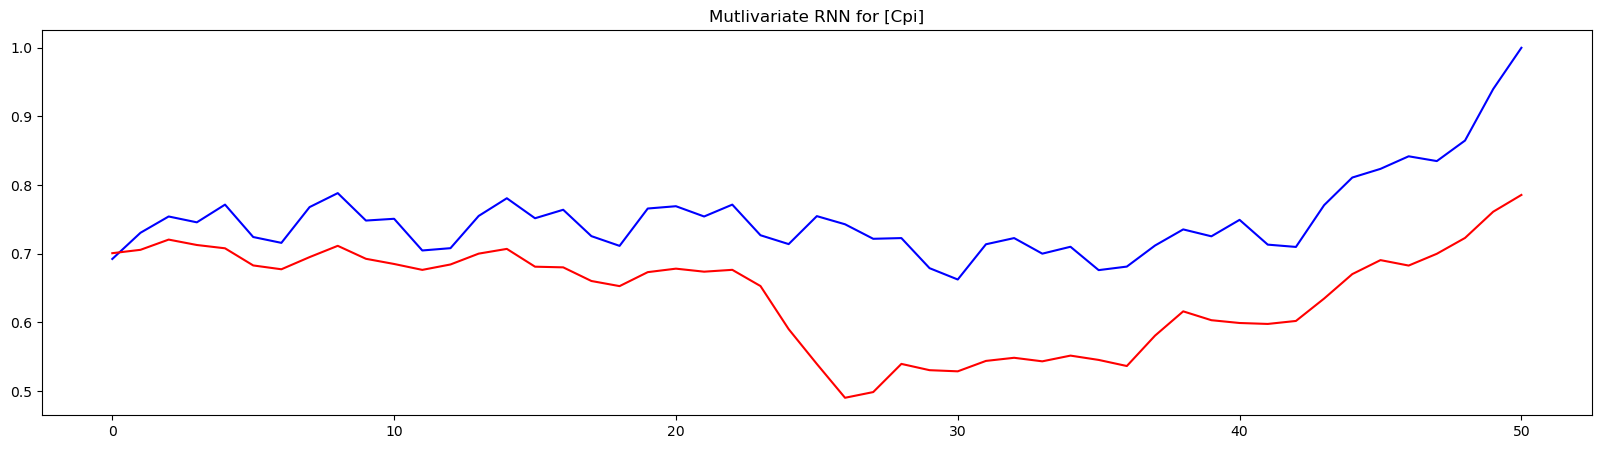

Multivariate RNN MSE for [Hicp]:0.0318495
Multivariate RNN RMSE for [Hicp]:0.17846428155757268
Multivariate RNN MAE for [Hicp]:0.16026497


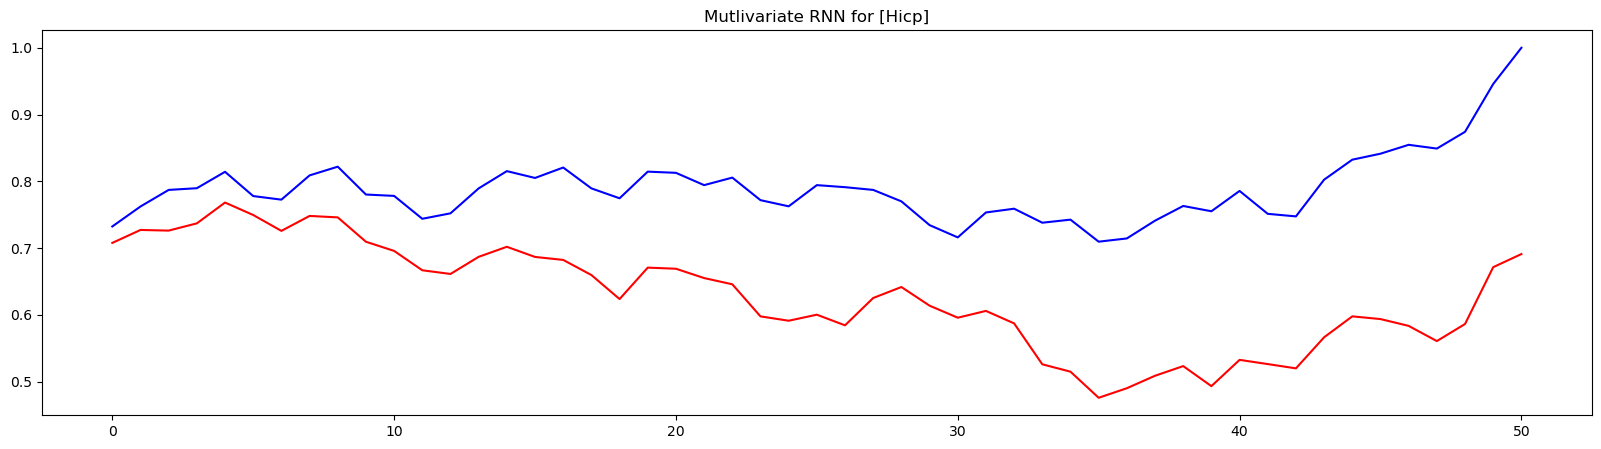




Cpi cols are ['Cpi', 'Food Price Index', 'Energy Price Index', 'Unemployment Rate', 'Gdp']
Hicp cols are ['Hicp', 'Food Price Index', 'Energy Price Index', 'Unemployment Rate', 'Gdp']


Multivariate RNN MSE for [Cpi]:0.0022939497
Multivariate RNN RMSE for [Cpi]:0.04789519510275
Multivariate RNN MAE for [Cpi]:0.042445313


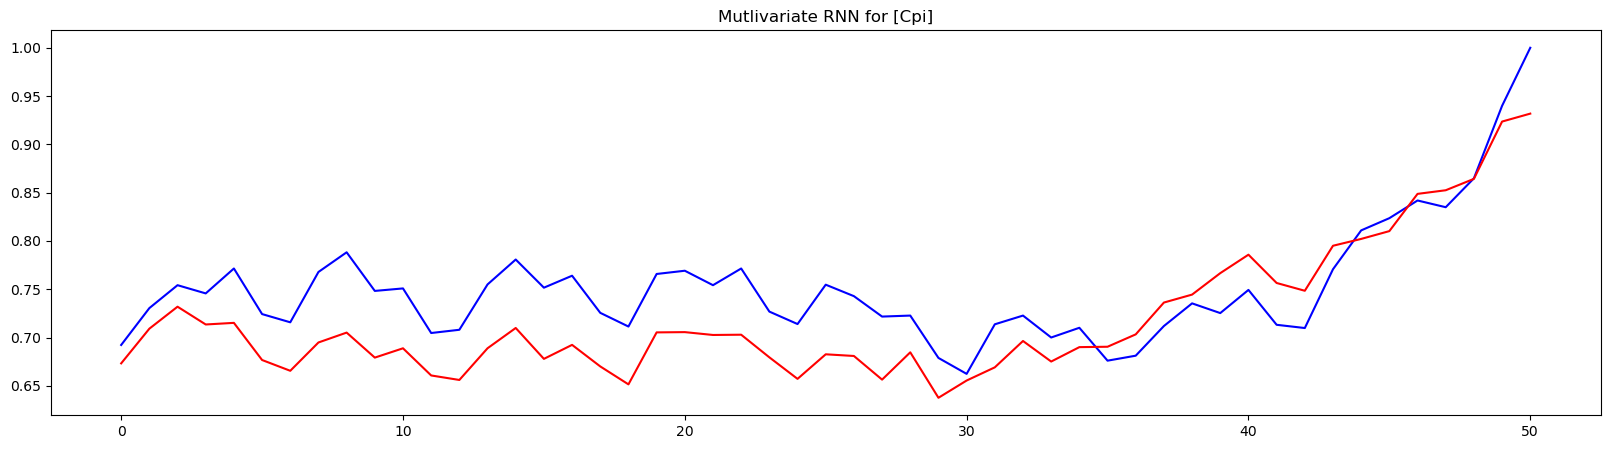

Multivariate RNN MSE for [Hicp]:0.020264983
Multivariate RNN RMSE for [Hicp]:0.14235513049126491
Multivariate RNN MAE for [Hicp]:0.13028964


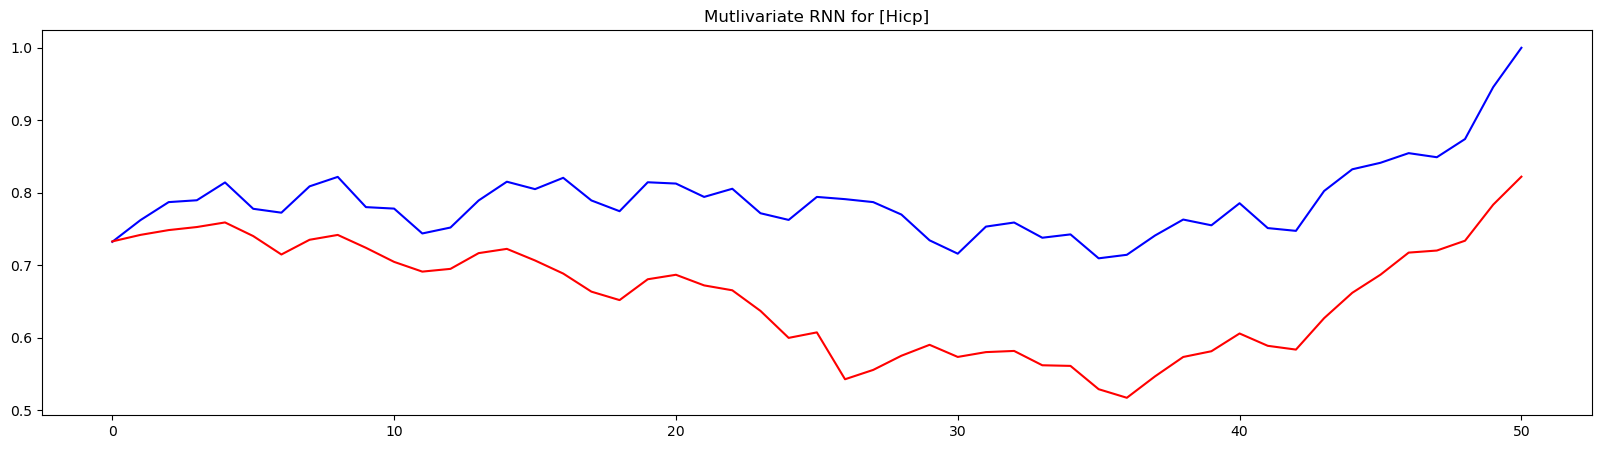




Cpi cols are ['Cpi', 'Food Price Index', 'Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price']
Hicp cols are ['Hicp', 'Food Price Index', 'Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price']


Multivariate RNN MSE for [Cpi]:0.005800939
Multivariate RNN RMSE for [Cpi]:0.07616389672972196
Multivariate RNN MAE for [Cpi]:0.06246437


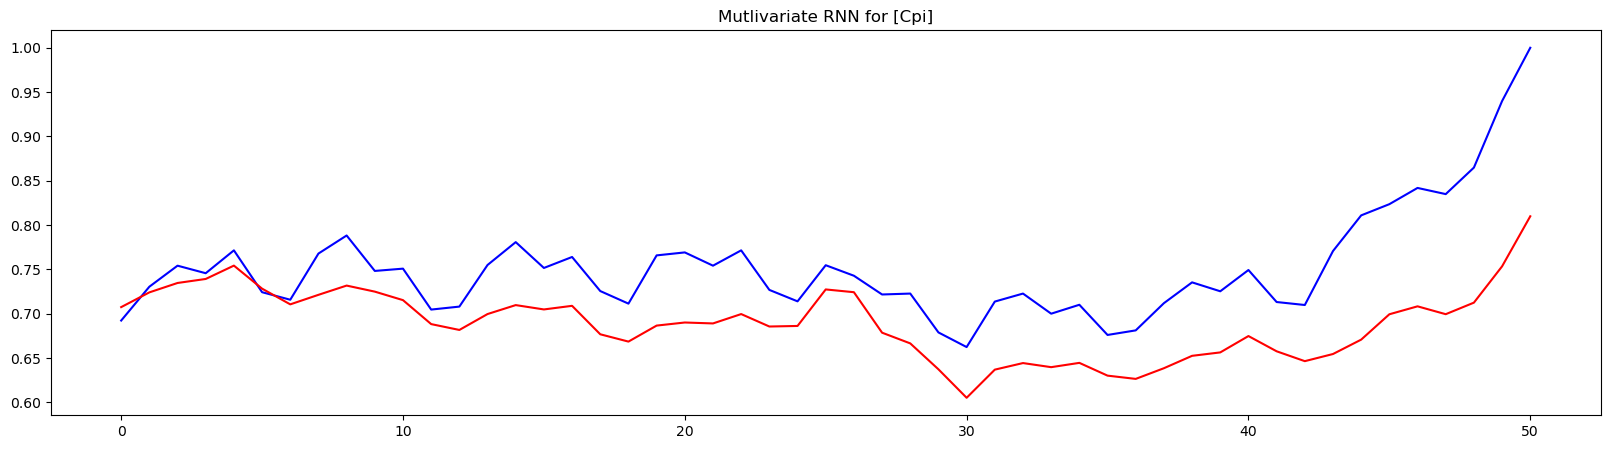

Multivariate RNN MSE for [Hicp]:0.008399213
Multivariate RNN RMSE for [Hicp]:0.09164721890440053
Multivariate RNN MAE for [Hicp]:0.08752206


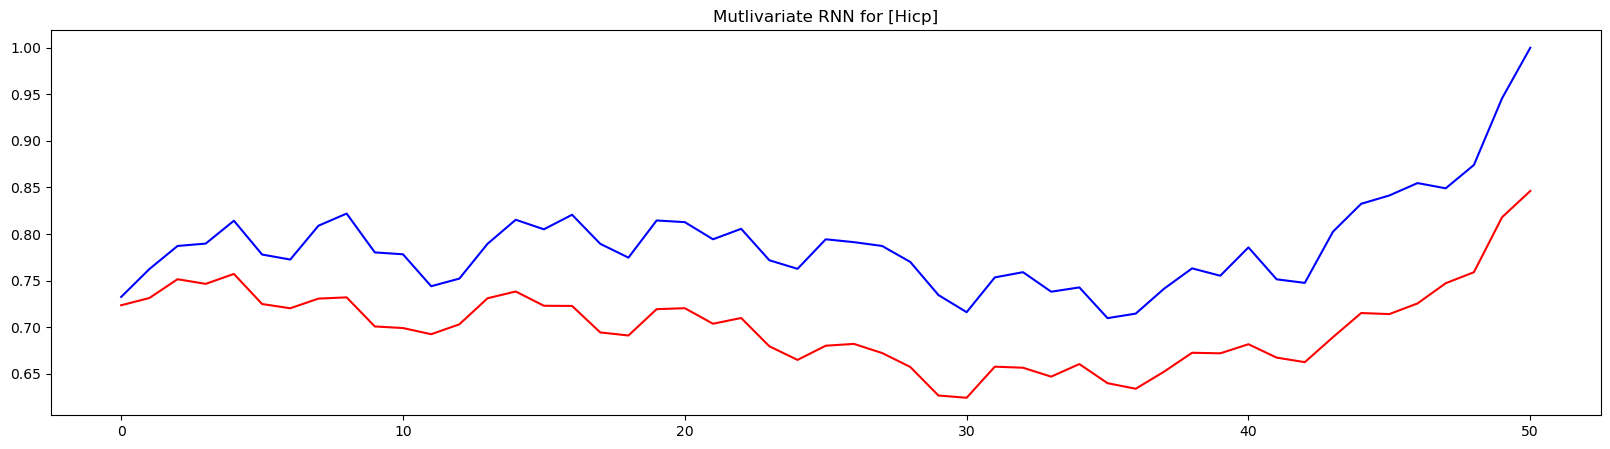




Cpi cols are ['Cpi', 'Food Price Index', 'Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices']
Hicp cols are ['Hicp', 'Food Price Index', 'Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices']


Multivariate RNN MSE for [Cpi]:0.0018072019
Multivariate RNN RMSE for [Cpi]:0.042511197190264964
Multivariate RNN MAE for [Cpi]:0.028305955


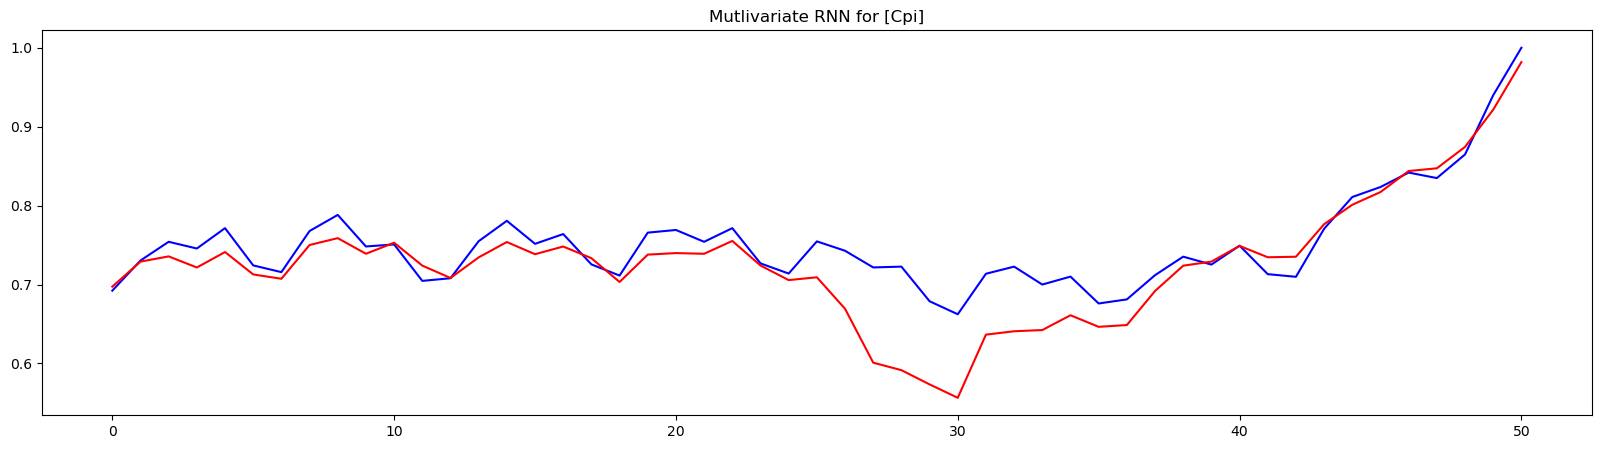

Multivariate RNN MSE for [Hicp]:0.0038918543
Multivariate RNN RMSE for [Hicp]:0.062384728212388045
Multivariate RNN MAE for [Hicp]:0.058899753


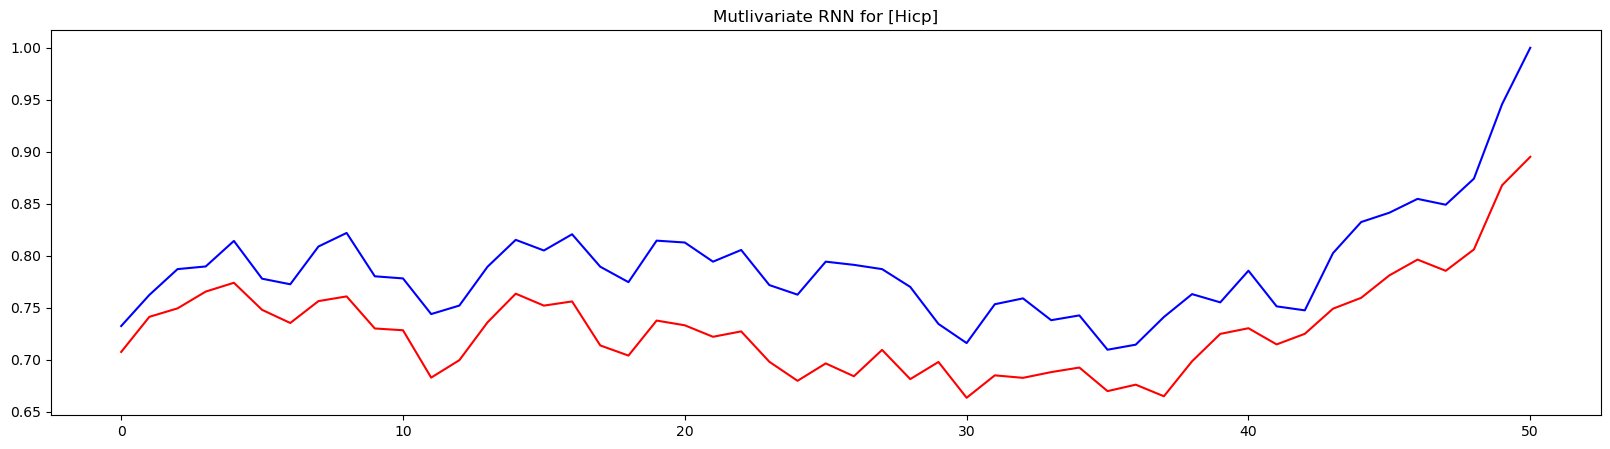




Cpi cols are ['Cpi', 'Food Price Index', 'Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices', 'Lci']
Hicp cols are ['Hicp', 'Food Price Index', 'Energy Price Index', 'Unemployment Rate', 'Gdp', 'Rent Price', 'House Prices', 'Lci']


Multivariate RNN MSE for [Cpi]:0.008778782
Multivariate RNN RMSE for [Cpi]:0.0936951526499574
Multivariate RNN MAE for [Cpi]:0.0853048


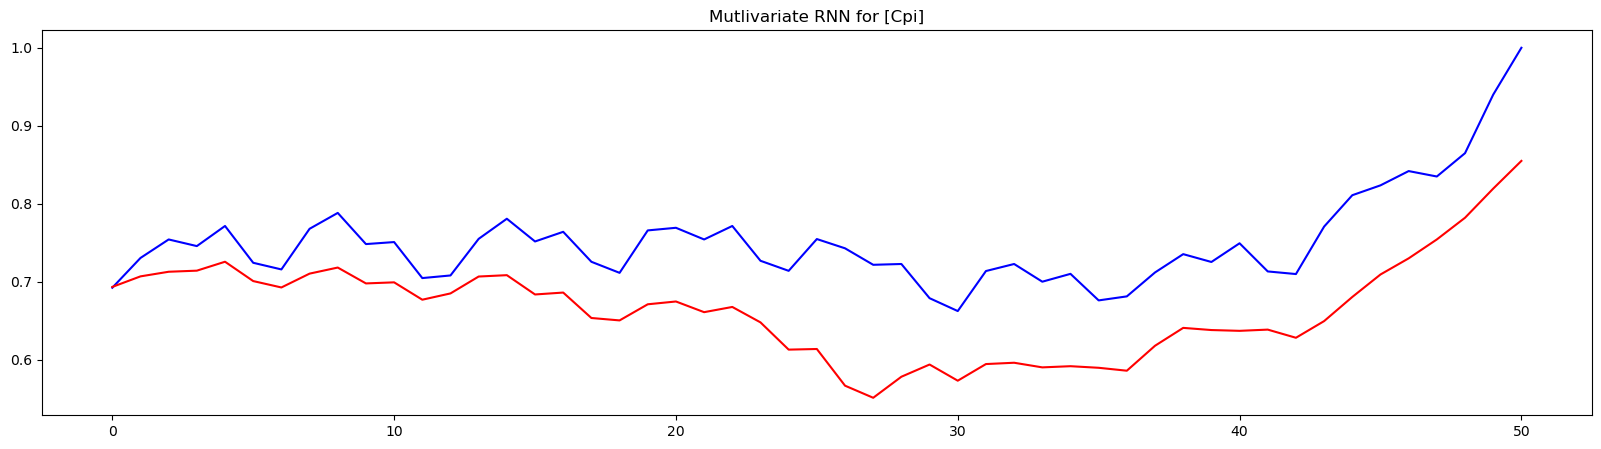

Multivariate RNN MSE for [Hicp]:0.004998244
Multivariate RNN RMSE for [Hicp]:0.07069825938116761
Multivariate RNN MAE for [Hicp]:0.052709


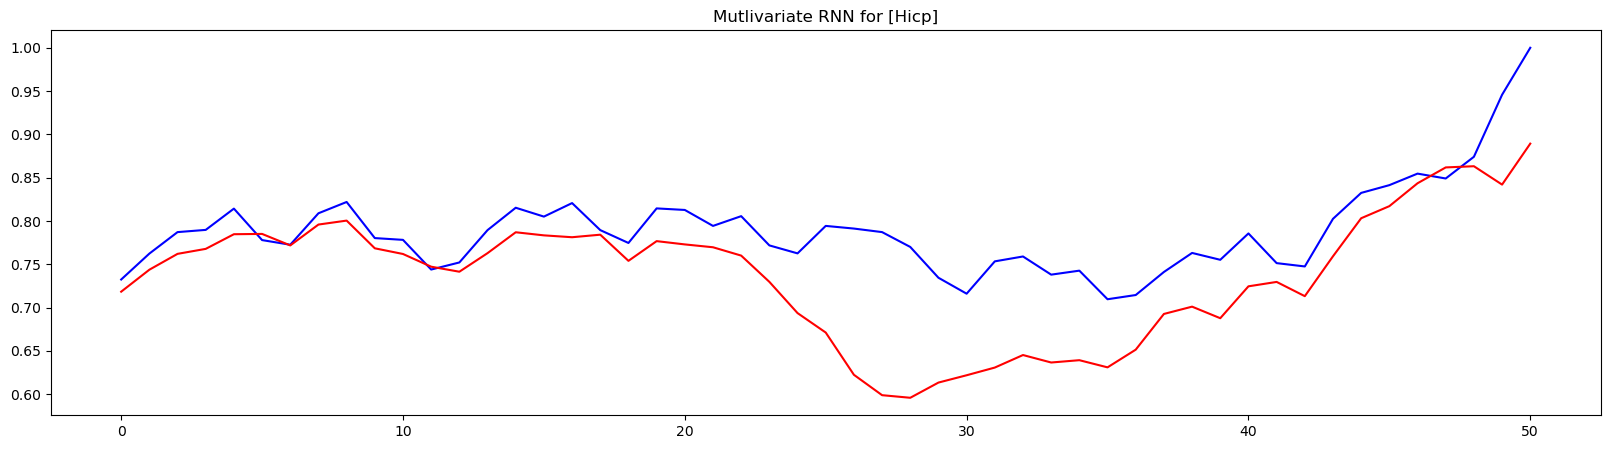

In [21]:
RNN_adding_cols()